# Purpose

* The purpose of this notebook is to demonstrate hyperparameter tuning via RandomizedSearchCV.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from scipy import stats

from xgboost import XGBClassifier

In [2]:
df1 = pd.read_csv('pima_indians_diabetes.csv')

In [3]:
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df1.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Splitting Data

In [18]:
df1.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [22]:
df1.Outcome.value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [24]:
# Weight
pos_weight = df1.Outcome.value_counts()[0]/df1.Outcome.value_counts()[1]
pos_weight

1.8656716417910448

In [51]:
X = df1.drop('Outcome', axis=1)
y = df1['Outcome'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)
# splitting the data 80:20 train:test

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train)
# splitting the training data 75:25 train:validation

In [52]:
print('Total training (X_train) data: ',X_train.shape)
print('Split training (X_train2) data',X_train2.shape)
print('Total testing (X_test) data: ',X_test.shape)
print('Total Validation (X_val) data: ',X_val.shape)

Total training (X_train) data:  (614, 8)
Split training (X_train2) data (460, 8)
Total testing (X_test) data:  (154, 8)
Total Validation (X_val) data:  (154, 8)


# Optimization

In [9]:
clf = XGBClassifier(n_jobs=-1)

In [26]:
params = dict(
    n_estimators = stats.randint(100,(2000-100)),
    max_depth = stats.randint(1,(20-1)),
    learning_rate = stats.loguniform(0.0001,1),
    gamma = stats.uniform(loc=0.0001,scale=10),
    subsample = stats.uniform(loc=0.5,scale=(1-.5)),
    colsample_bytree = stats.uniform(loc=0.5,scale=(1-.5)),
    scale_pos_weight = [None, pos_weight]
)

In [30]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

rand_search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=50, cv=cv, n_jobs=-1, scoring='roc_auc')

In [31]:
%%time
rand_search.fit(X_train2,y_train2)

C:\Users\bjohn\miniconda3\envs\DS_JAN2023\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bjohn\miniconda3\envs\DS_JAN2023\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:43:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 23.1 s
Wall time: 6min 53s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025F6D0BA9E0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025F6CFF9060>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025F703A15D0>,
                                        'scale_pos_weight': [None,
                                                             1.8656716417910448],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025F728CFC70>},
                   scoring='roc_auc')

In [32]:
rand_search.best_params_

{'colsample_bytree': 0.5121615869608875,
 'gamma': 8.182280897719899,
 'learning_rate': 0.004343334809669429,
 'max_depth': 13,
 'n_estimators': 1774,
 'scale_pos_weight': 1.8656716417910448,
 'subsample': 0.7124719615714563}

In [33]:
rand_search.best_score_

0.825

In [37]:
results = pd.DataFrame(rand_search.cv_results_).sort_values(by='mean_test_score',ascending=False).head().reset_index(drop=True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,79.856591,1.590559,0.017902,0.014583,0.512162,8.182281,0.004343,13,1774,1.865672,0.712472,"{'colsample_bytree': 0.5121615869608875, 'gamm...",0.835938,0.834375,0.773958,0.830208,0.850521,0.825000,0.026424,1
1,29.852430,0.096194,0.006400,0.000800,0.520269,8.049863,0.003772,5,1440,1.865672,0.624182,"{'colsample_bytree': 0.520268577507047, 'gamma...",0.837500,0.831771,0.777604,0.831250,0.845312,0.824687,0.024082,2
2,16.921404,0.284084,0.006800,0.001166,0.600725,5.245592,0.000361,2,1830,1.865672,0.578257,"{'colsample_bytree': 0.6007250310943477, 'gamm...",0.835938,0.822396,0.785937,0.835417,0.843229,0.824583,0.020456,3
3,46.618097,0.402354,0.006702,0.000748,0.811535,5.128924,0.001427,11,1404,None,0.501501,"{'colsample_bytree': 0.811535412722209, 'gamma...",0.841667,0.822396,0.772396,0.834375,0.845833,0.823333,0.026683,4
4,63.300256,0.809756,0.007200,0.000748,0.835802,7.241058,0.000673,18,1520,1.865672,0.661377,"{'colsample_bytree': 0.835801822995606, 'gamma...",0.842187,0.817187,0.783333,0.827083,0.844271,0.822812,0.022110,5


In [40]:
params = results.iloc[2]['params']
params

{'colsample_bytree': 0.6007250310943477,
 'gamma': 5.245591857607449,
 'learning_rate': 0.0003611618264278944,
 'max_depth': 2,
 'n_estimators': 1830,
 'scale_pos_weight': 1.8656716417910448,
 'subsample': 0.5782568291434824}

# VaOutcomedating the GridSearchCV best_params_

In [41]:
%%time
xgbc = XGBClassifier(**params,n_jobs=-1).fit(X_train2,y_train2)

C:\Users\bjohn\miniconda3\envs\DS_JAN2023\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bjohn\miniconda3\envs\DS_JAN2023\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:50:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 5.16 s
Wall time: 760 ms


In [42]:
y_pred = xgbc.predict(X_val)

In [43]:
print('Validation')
print(classification_report(y_val,y_pred))
print(confusion_matrix(y_val,y_pred))

Validation
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       101
           1       0.54      0.72      0.61        53

    accuracy                           0.69       154
   macro avg       0.68      0.70      0.68       154
weighted avg       0.72      0.69      0.70       154

[[68 33]
 [15 38]]


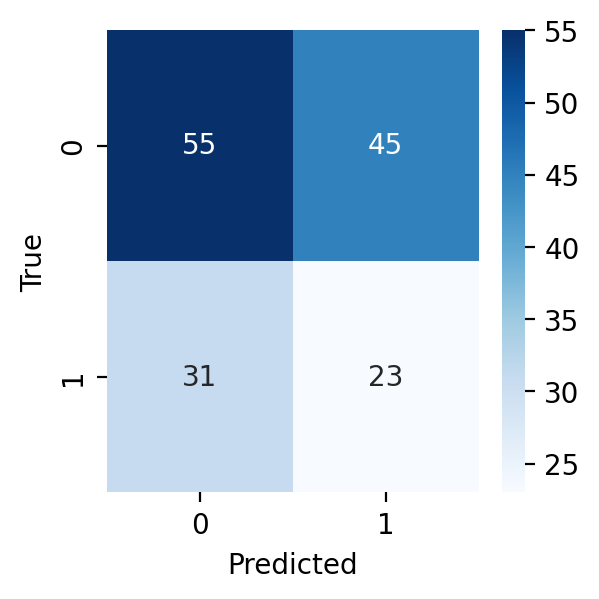

In [57]:
plt.figure(figsize=(3,3),dpi=200)
cm = confusion_matrix(y_val, y_pred)
cmd = sns.heatmap(cm, annot=True,cmap='Blues')
cmd.set_xlabel('Predicted')
cmd.set_ylabel('True')
plt.show()

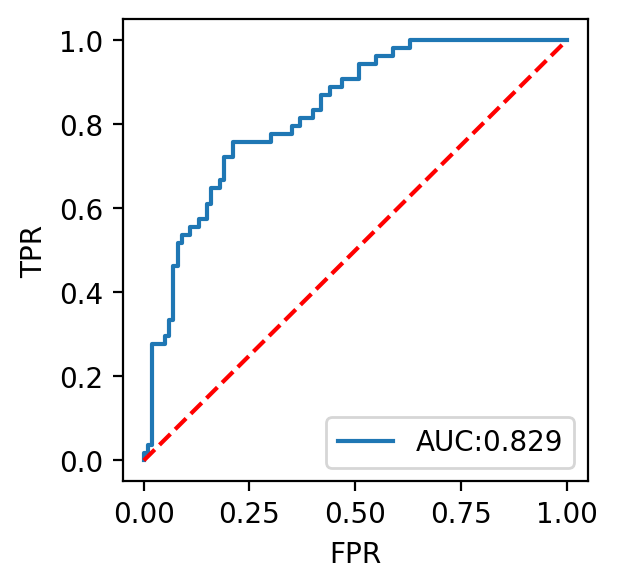

In [55]:
proba1 = xgbc.predict_proba(X_val)
fpr,tpr,threshold = roc_curve(y_val, proba1[:,1],drop_intermediate=False)
auc1 = auc(fpr,tpr)

plt.figure(figsize=(3,3),dpi=200)
plt.plot(fpr,tpr, label=f'AUC:{auc1:.3f}')
plt.legend(loc=0)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

**Re-tune if you are not satisfied with the Validation**<br>
<br>
**If you are done hyperparam tuning, then test the model**

# Testing the model

In [46]:
y_pred = xgbc.predict(X_test)

print("Testing")
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Testing
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        99
           1       0.65      0.80      0.72        55

    accuracy                           0.77       154
   macro avg       0.76      0.78      0.76       154
weighted avg       0.79      0.77      0.78       154

[[75 24]
 [11 44]]


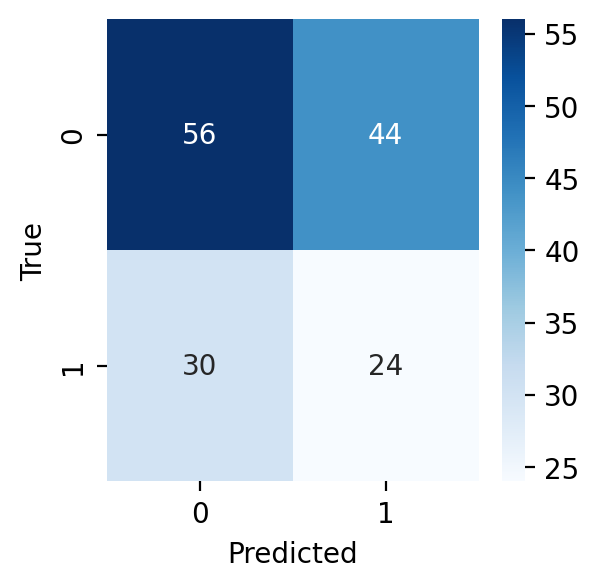

In [56]:
plt.figure(figsize=(3,3),dpi=200)
cm = confusion_matrix(y_test, y_pred)
cmd = sns.heatmap(cm,annot=True,cmap='Blues')
cmd.set_ylabel('True')
cmd.set_xlabel('Predicted')
plt.show()

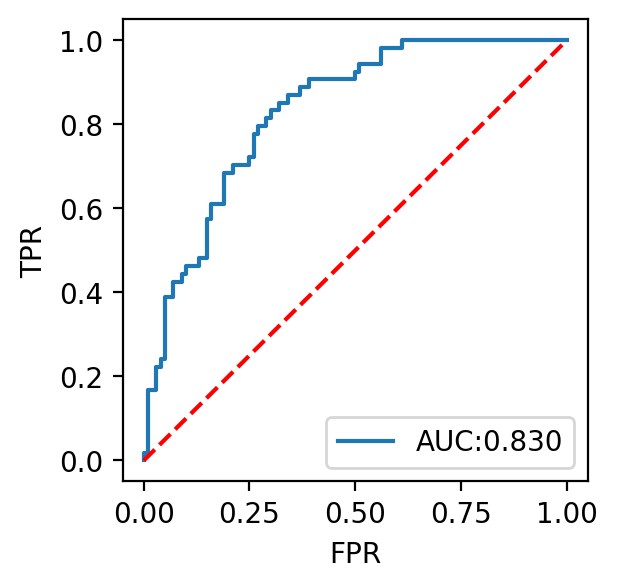

In [58]:
proba1 = xgbc.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test, proba1[:,1],drop_intermediate=False)
auc2 = auc(fpr,tpr)

plt.figure(figsize=(3,3),dpi=200)
plt.plot(fpr,tpr, label=f'AUC:{auc2:.3f}')
plt.legend(loc=0)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()